#### Clustering on Country Data

In [1]:
import pandas as pd
import numpy as np

from sklearn import cluster, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [2]:
country_data = pd.read_csv('data/Country-data.csv')
data_dict = pd.read_csv('data/data-dictionary.csv')

In [3]:
display(data_dict)

,Column Name,Description
0,country,Name of the country
1,child_mort,Death of children under 5 years of age per 100...
2,exports,Exports of goods and services per capita. Give...
3,health,Total health spending per capita. Given as %ag...
4,imports,Imports of goods and services per capita. Give...
5,Income,Net income per person
6,Inflation,The measurement of the annual growth rate of t...
7,life_expec,The average number of years a new born child w...
8,total_fer,The number of children that would be born to e...
9,gdpp,The GDP per capita. Calculated as the Total GD...


In [4]:
print('Shape: ', country_data.shape)
country_data.head()

Shape:  (167, 10)


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [5]:
country_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [6]:
country_data.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [7]:
df = country_data.iloc[:, 1:]

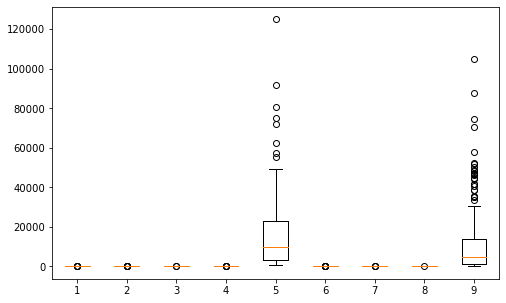

In [8]:
plt.figure(figsize = (8,5))
plt.boxplot(df)
plt.show()

The data needs to be standardized

#### Let us first experiment how clustering performs without Standardizing and Principle Component Analysis on our initial variables

In [9]:
def df_scatterplot(df, cluster_labels, title):
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(25,10))
    for i, feature in enumerate(df.iloc[:,df.columns != 'exports'].columns):
        r = 0 if(i < 4) else 1
        c = i if(i < 4) else i-4
        colors = ['r', 'g', 'b']
        ax[r,c].set_title(feature)
        for a,lbl in enumerate(np.unique(cluster_labels)):
            ax[r,c].scatter(df.loc[cluster_labels == lbl,'exports'], df.loc[cluster_labels == lbl,feature], c=colors[a], label=f'Class {lbl}')
        ax[r,c].legend()
    #plt.tight_layout()
    plt.suptitle(title,fontsize=21)
    plt.show()

In [10]:
km = cluster.KMeans(3)
km_labels = km.fit_predict(df)

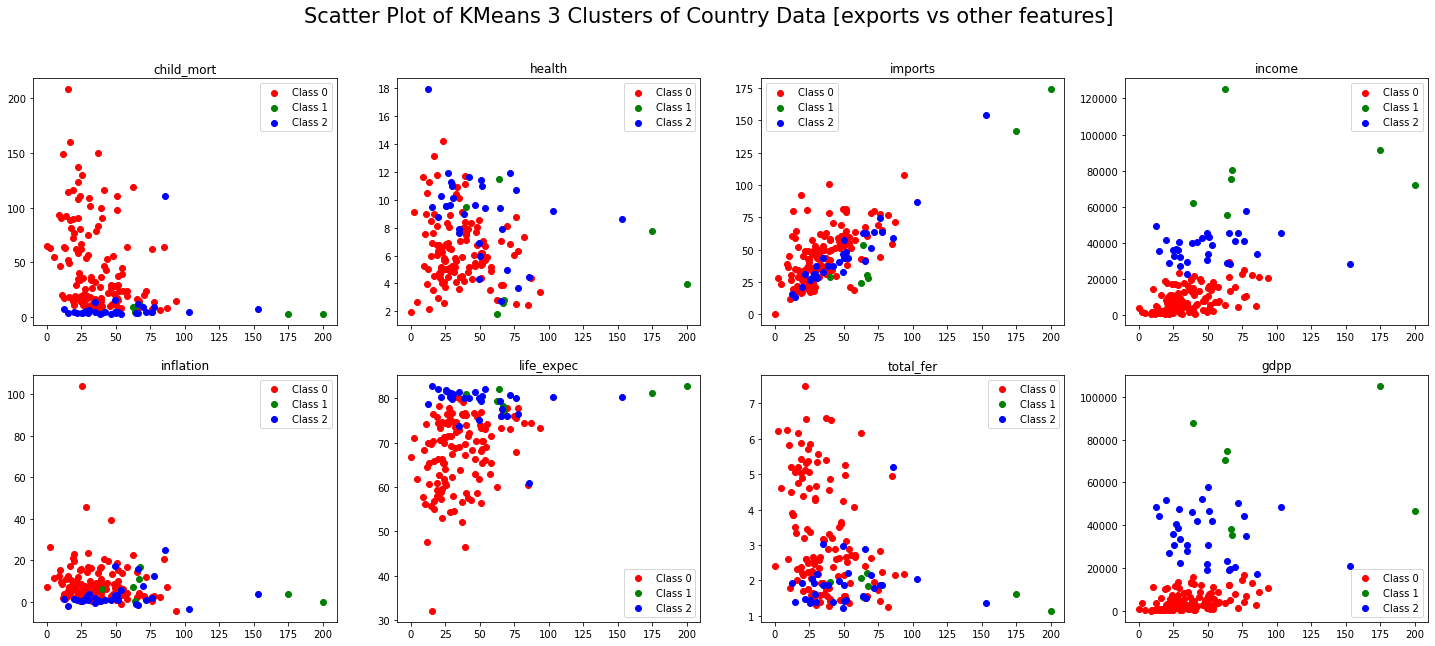

In [11]:
df_scatterplot(df, km_labels, 'Scatter Plot of KMeans 3 Clusters of Country Data [exports vs other features]')

It certainly does not give us any convincing results

#### Let's try if we get good clusters after PCA

In [12]:
sc = StandardScaler()
df_std = sc.fit_transform(df)
pca = PCA()
countries_pca = pca.fit_transform(df_std)

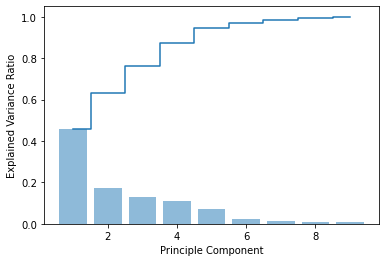

In [13]:
plt.bar(range(1,10), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1,10), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principle Component')
plt.show()

#### Using first 2 Principle Components for Clustering

In [14]:
km = cluster.KMeans(3)
km_labels = km.fit_predict(countries_pca)

No handles with labels found to put in legend.


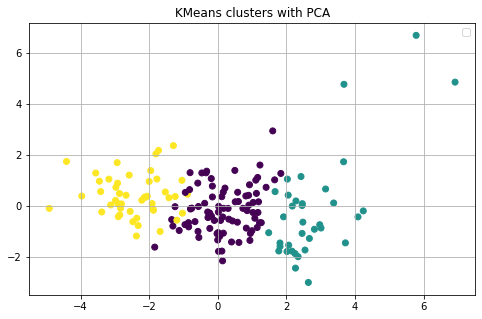

In [15]:
plt.figure(figsize=(8,5))
plt.grid(True)
plt.title('KMeans clusters with PCA')
plt.scatter(countries_pca[:,0], countries_pca[:,1], c=km_labels)
plt.legend()
plt.show()

In [16]:
country_data['km_classes'] = km_labels

(country_data['km_classes'].value_counts()/country_data.shape[0])*100

0    50.299401
2    28.143713
1    21.556886
Name: km_classes, dtype: float64

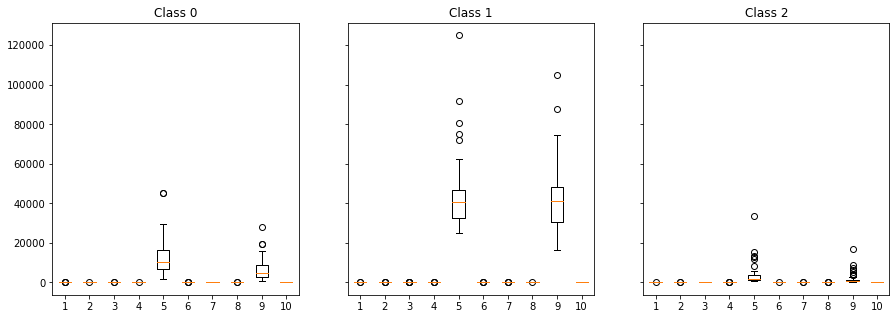

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
for i in range(0,3):
    ax[i].set_title(f'Class {i}')
    ax[i].boxplot(country_data.iloc[km_labels==i,1:])
plt.show()

Clusters anticipated class

In [19]:
categories = {0: 'developing country',
              2: 'under-developing country',
              1: 'developed country'}

country_data['anticipated_class'] = country_data['km_classes'].map(categories)

country_data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,km_classes,anticipated_class
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,2,under-developing country
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,0,developing country
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,0,developing country
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,2,under-developing country
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,0,developing country
